author: @SteveEckel

Let's simulate a recoil-limited MOT like the Sr red MOT.  Let's use the bosonic isotope, and as a first pass we'll use the heuristic equation.  We can compare to R.K. Hanley, P. Huillery, N.C. Keegan, A.D. Bounds, D. Boddy, R. Faoro, and M.P.A. Jones, "Quantitative simulation of a magneto-optical trap operating near the photon recoil limit" *Journal of Modern Optics* **65**, 667 (2018). https://dx.doi.org/10.1080/09500340.2017.1401679

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import scipy.constants as cts
from pylcp.common import progressBar
savefigs = True

Let's calculate things for $^{88}$Sr:

In [2]:
k = 2*np.pi/689E-7    # cm^{-1}
x0 = 1/k              # our length scale in cm
gamma = 2*np.pi*7.5e3 # 7.5 kHz linewidth
t0 = 1/gamma          # our time scale in s

# Magnetic field gradient parameter (the factor of 3/2 comes from the 
# excited state g-factor.)
alpha = (3/2)*cts.value('Bohr magneton in Hz/T')*1e-4*8*x0/7.5E3

# The unitless mass parameter:
mass = 87.8*cts.value('atomic mass constant')*(x0*1e-2)**2/cts.hbar/t0

# Gravity
g = -np.array([0., 0., 9.8*t0**2/(x0*1e-2)])

print(x0, t0, mass, alpha, g)

1.0965775579031588e-05 2.1220659078919377e-05 0.7834067174281623 0.02455674894694879 [-0.         -0.         -0.04024431]


### Now define the problem:

In [3]:
beta = 25
det = -200/7.5

magField = pylcp.quadrupoleMagneticField(alpha)

laserBeams = pylcp.conventional3DMOTBeams(delta=det, beta=beta,
                                          beam_type=pylcp.infinitePlaneWaveBeam)

Hg, mugq = pylcp.hamiltonians.singleF(F=0, muB=1)
He, mueq = pylcp.hamiltonians.singleF(F=1, muB=1)

dq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

hamiltonian = pylcp.hamiltonian(Hg, He, mugq, mueq, dq, mass=mass)

#eqn = pylcp.heuristiceq(laserBeams, magField, g, mass=mass)
eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, g)

### Generate a force profile: 

We can compare this to Fig. 1.

Text(0, 0.5, '$F/(\\hbar k \\Gamma)$')

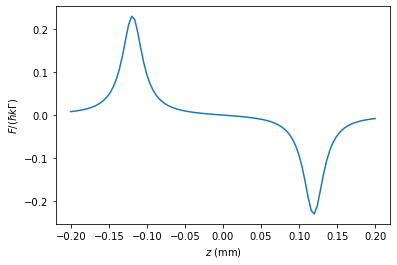

In [4]:
z = np.linspace(-0.2, 0.2, 101)/(10*x0)

R = np.array([np.zeros(z.shape), np.zeros(z.shape), z])
V = np.zeros((3,) + z.shape)

eqn.generate_force_profile(R, V, name='Fz')

fig, ax = plt.subplots(1, 1)

ax.plot(z*(10*x0), eqn.profile['Fz'].F[2])
ax.set_xlabel('$z$ (mm)')
ax.set_ylabel('$F/(\hbar k \Gamma)$')

Note in the paper they have the $F$ in units of N.  When adding the $\hbar k \Gamma$ to mine, I find my force is a factor of 2 lower than theirs in the plot.

### Run a test solution:

In [5]:
tmax = 0.05/t0
if isinstance(eqn, pylcp.rateeq):
    eqn.set_initial_pop(np.array([1., 0., 0., 0.]))
eqn.set_initial_position(np.array([0., 0., 0.]))
eqn.evolve_motion([0, 0.05/t0], random_recoil=True, progress_bar=True, max_step=1.)

Completed in 17.56 s.                                               


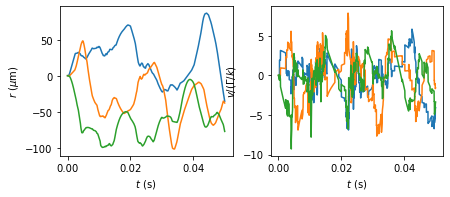

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ax[0].plot(eqn.sol.t*t0, eqn.sol.r.T*(1e4*x0))
ax[1].plot(eqn.sol.t*t0, eqn.sol.v.T)
ax[0].set_ylabel('$r$ ($\mu$m)')
ax[0].set_xlabel('$t$ (s)')
ax[1].set_ylabel('$v/(\Gamma/k)$')
ax[1].set_xlabel('$t$ (s)')
fig.subplots_adjust(left=0.08, wspace=0.22)

### Now drop a bunch of atoms in and see what happens:

Using `pathos` package to do parallel processing

In [7]:
import pathos

if hasattr(eqn, 'sol'):
    del eqn.sol

def generate_random_solution(x, eqn=eqn, tmax=tmax):
    # We need to generate random numbers to prevent solutions from being seeded
    # with the same random number.
    import numpy as np

    np.random.rand(256*x)
    eqn.evolve_motion(
        [0, tmax], 
        t_eval=np.linspace(0, tmax, 1001),
        random_recoil=True,
        progress_bar=False,
        max_step=1.
    )
    
    return eqn.sol

Natoms = 1024
chunksize = 4
sols = []
progress = progressBar()
for jj in range(int(Natoms/chunksize)):
    with pathos.pools.ProcessPool(nodes=4) as pool:
        sols += pool.map(generate_random_solution, range(chunksize))
    progress.update((jj+1)/(Natoms/chunksize))

Completed in 1:36:15.                                               


Plot up all the trajectories:

53


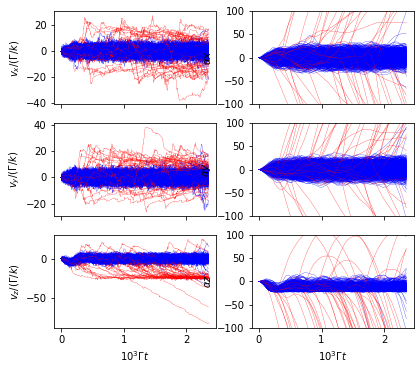

In [8]:
ejected = [np.bitwise_or(
    np.abs(sol.r[0, -1]*(1e4*x0))>500,
    np.abs(sol.r[1, -1]*(1e4*x0))>500
) for sol in sols]        

print(np.sum(ejected))
fig, ax = plt.subplots(3, 2, figsize=(6.25, 2*2.75))
for sol, ejected_i in zip(sols, ejected):
    for ii in range(3):
        if ejected_i:
            ax[ii, 0].plot(sol.t/1e3, sol.v[ii], color='r', linewidth=0.25)
            ax[ii, 1].plot(sol.t/1e3, sol.r[ii]*alpha, color='r', linewidth=0.25)
        else:
            ax[ii, 0].plot(sol.t/1e3, sol.v[ii], color='b', linewidth=0.25)
            ax[ii, 1].plot(sol.t/1e3, sol.r[ii]*alpha, color='b', linewidth=0.25)                

"""for ax_i in ax[:, 0]:
    ax_i.set_ylim((-0.75, 0.75))
for ax_i in ax[:, 1]:
    ax_i.set_ylim((-4., 4.))"""
for ax_i in ax[-1, :]:
    ax_i.set_xlabel('$10^3 \Gamma t$')
for jj in range(2):
    for ax_i in ax[jj, :]:
        ax_i.set_xticklabels('')
for ax_i, lbl in zip(ax[:, 0], ['x','y','z']):
    ax_i.set_ylabel('$v_' + lbl + '/(\Gamma/k)$')
for ax_i, lbl in zip(ax[:, 1], ['x','y','z']):
    ax_i.set_ylim((-100, 100))
    ax_i.set_ylabel('$\\alpha ' + lbl + '$')
    
fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.22)

Now, every 0.1 ms, bin the $x$ and $z$ coordinates, make a histogram, and simulate an image:

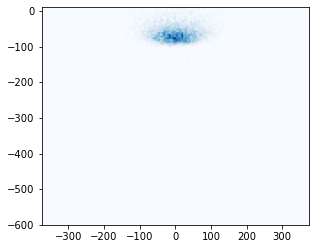

In [9]:
allx = np.array([], dtype='float64')
allz = np.array([], dtype='float64')

for sol in sols:
    allx = np.append(allx, sol.r[0][200::100]*(1e4*x0))
    allz = np.append(allz, sol.r[2][200::100]*(1e4*x0))
    
img, x_edges, z_edges = np.histogram2d(allx, allz, bins=[np.arange(-375, 376, 5.), np.arange(-600., 11., 5.)])

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img.T, origin='bottom',
               extent=(np.amin(x_edges), np.amax(x_edges),
                       np.amin(z_edges), np.amax(z_edges)),
               cmap='Blues',
               aspect='equal')

### Now, let's run the detuning

And produce the resulting simulated MOT images

In [11]:
dets = np.array([det, -400/7.5, -600/7.5, -800/7.5])
#beta = 9

imgs = np.zeros(dets.shape + img.shape)
num_of_ejections = np.zeros(dets.shape)
num_of_ejections[0] = np.sum(ejected)
imgs[0] = img

for ii, det in enumerate(dets[1:]):
    # Rewrite the laser beams with the new detuning and beta
    laserBeams = pylcp.conventional3DMOTBeams(delta=det, beta=beta,
                                              beam_type=pylcp.infinitePlaneWaveBeam)
    
    # Make the equation:
    eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, g)
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop(np.array([1., 0., 0., 0.]))
        
    # Use the last equilibrium position to set this position:
    eqn.set_initial_position(np.array([0., 0., np.mean(allz)]))
    
    # Re-define the random soluton:
    def generate_random_solution(x, eqn=eqn, tmax=tmax):
        # We need to generate random numbers to prevent solutions from being seeded
        # with the same random number.
        import numpy as np

        np.random.rand(256*x)
        eqn.evolve_motion(
            [0, tmax], 
            t_eval=np.linspace(0, tmax, 1001),
            random_recoil=True,
            progress_bar=False,
            max_step=1.
        )
    
        return eqn.sol

    # Generate the solution:
    sols = []
    progress = progressBar()
    for jj in range(int(Natoms/chunksize)):
        with pathos.pools.ProcessPool(nodes=4) as pool:
            sols += pool.map(generate_random_solution, range(chunksize))
        progress.update((jj+1)/(Natoms/chunksize))
    
    # Generate the image:
    allx = np.array([], dtype='float64')
    allz = np.array([], dtype='float64')

    for sol in sols:
        allx = np.append(allx, sol.r[0][200::100]*(1e4*x0))
        allz = np.append(allz, sol.r[2][200::100]*(1e4*x0))

    img, x_edges, z_edges = np.histogram2d(allx, allz, bins=[x_edges, z_edges])
    
    # Save the image:
    imgs[ii+1] = img
    
    # Count the number of ejections:
    num_of_ejections[ii+1] = np.sum([np.bitwise_or(
        np.abs(sol.r[0, -1]*(1e4*x0))>500,
        np.abs(sol.r[1, -1]*(1e4*x0))>500
    ) for sol in sols])

Completed in 1:24:09.                                               
Completed in 1:20:34.                                               
Completed in 1:21:06.                                               


Print out the statistics of the ejections:

In [13]:
print('Number of ejections: ', num_of_ejections)
print('Estimated lifetime: ', (-np.log((Natoms-num_of_ejections)/Natoms)/(tmax*t0)))

Number of ejections:  [53. 34. 34. 33.]
Estimated lifetime:  [1.06290675 0.67533725 0.67533725 0.65514543]


Now plot it up, with the ellipse indicating when the Zeeman shift from the magnetic field gradient equals the detuning 

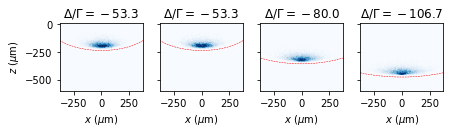

In [19]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 4, figsize=(6.5, 1.95))

for ii in range(4):
    ax[ii].imshow(imgs[ii].T, origin='bottom',
                  extent=(np.amin(x_edges), np.amax(x_edges),
                          np.amin(z_edges), np.amax(z_edges)),
                  cmap='Blues', clim=(0,25))
    ax[ii].set_title('$\Delta/\Gamma = %.1f$'%dets[ii])
    ax[ii].set_xlabel('$x$ ($\mu$m)')
    
    ellip = Ellipse(xy=(0,0),
                    width=4*dets[ii]/alpha*(1e4*x0),
                    height=2*dets[ii]/alpha*(1e4*x0),
                    linestyle='--',
                    linewidth=0.5,
                    facecolor='none',
                    edgecolor='red')
       
    ax[ii].add_patch(ellip)
    if ii>0:
        ax[ii].yaxis.set_ticklabels('')

ax[0].set_ylabel('$z$ ($\mu$m)')

fig.subplots_adjust(left=0.08, bottom=0.1)
if savefigs:
    fig.savefig('88Sr_red_MOT_differnt_detunings.pdf')